In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [14]:
# Calculate the date 1 year ago from the last data point in the database
session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

#querydate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
#dt.datetime.strptime(querydate, "%Y-%m-%d")

# last data point

'2017-08-23'

In [15]:
year_ago = dt.date.today() - dt.timedelta(days=365)


In [16]:
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

Query Date:  2016-08-23


In [17]:
# Perform a query to retrieve the date and precipitation scores
date_prcp = session.query(Measurement.date, func.sum(Measurement.prcp)).group_by(Measurement.date).\
    filter(Measurement.date >= query_date).all()

In [18]:
# Save the query results as a Pandas DataFrame and set the index to the date column
date_prcp_df = pd.DataFrame(date_prcp, columns = ["date","prcp"])

# Sort the dataframe by date
date_prcp_df.set_index("date")

,prcp
date,
2016-08-23,2.71
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32
...,...
2017-08-19,0.09
2017-08-20,0.01
2017-08-21,0.58


In [19]:
dates = date_prcp_df["date"]
dates_ct = date_prcp_df["prcp"].count()

xticks = [date for date in range(0,dates_ct,30)]
labels = [dates[x] for x in range(0,dates_ct,30)]
labels
# for x in range(0,dates,30):

['2016-08-23',
 '2016-09-22',
 '2016-10-22',
 '2016-11-21',
 '2016-12-21',
 '2017-01-20',
 '2017-02-19',
 '2017-03-21',
 '2017-04-20',
 '2017-05-20',
 '2017-06-19',
 '2017-07-19',
 '2017-08-18']

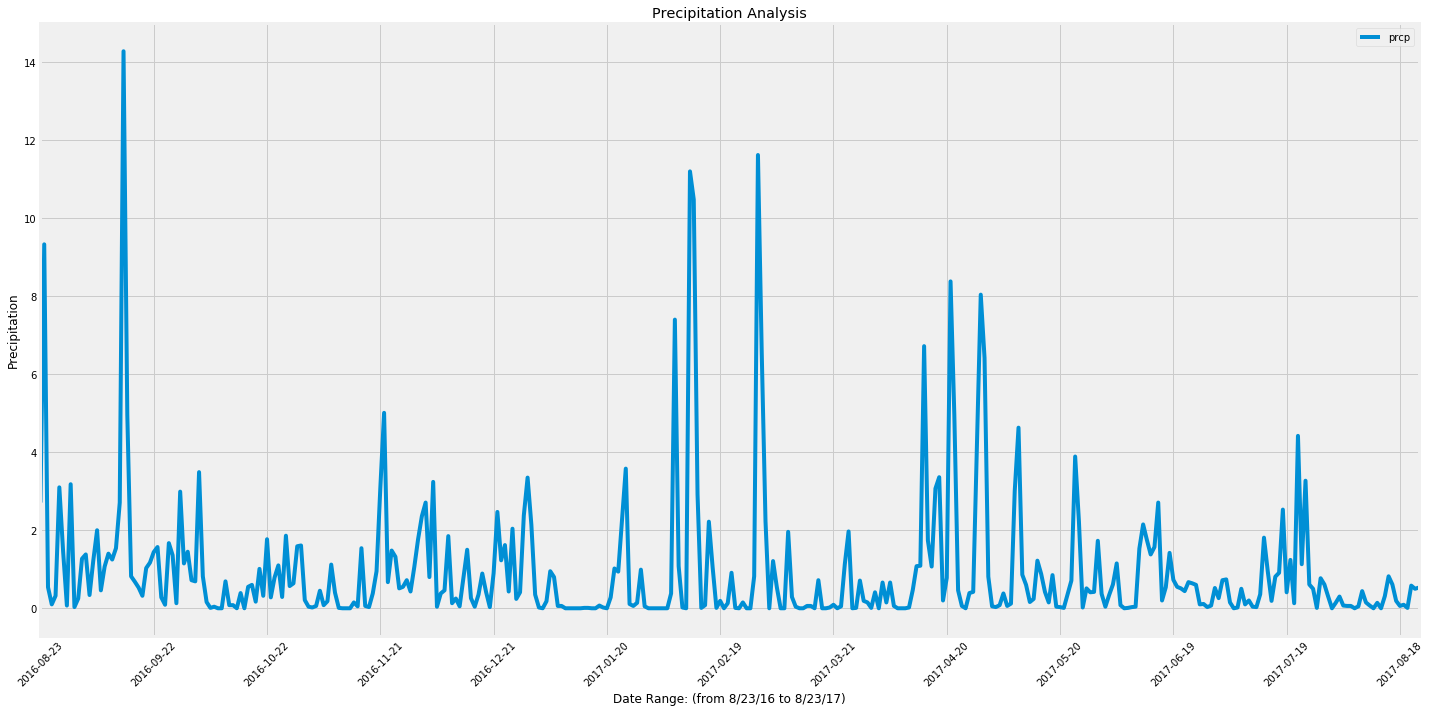

In [20]:
# Use Pandas Plotting with Matplotlib to plot the data
fix, ax = plt.subplots(figsize=(20,10))
date_prcp_df.plot(ax=ax)
plt.grid(True)
plt.xlabel("Date Range: (from 8/23/16 to 8/23/17)")
# plt.set_xticklabels(labels)
plt.xticks(xticks,labels,rotation=45)
plt.ylabel("Precipitation")
plt.title("Precipitation Analysis")
plt.legend()
plt.tight_layout()
plt.show()

![precipitation](Images/precipitation.png)

In [28]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_prcp_df.describe()

,prcp
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


![describe](Images/describe.png)

In [38]:
# Design a query to show how many stations are available in this dataset?
stations_count = session.query(func.distinct(Measurement.station)).count()
stations_count

9

In [40]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [45]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).all()

[(53.0, 87.0, 73.09795396419437)]

Text(0.5, 1.0, 'Temperature for the Year')

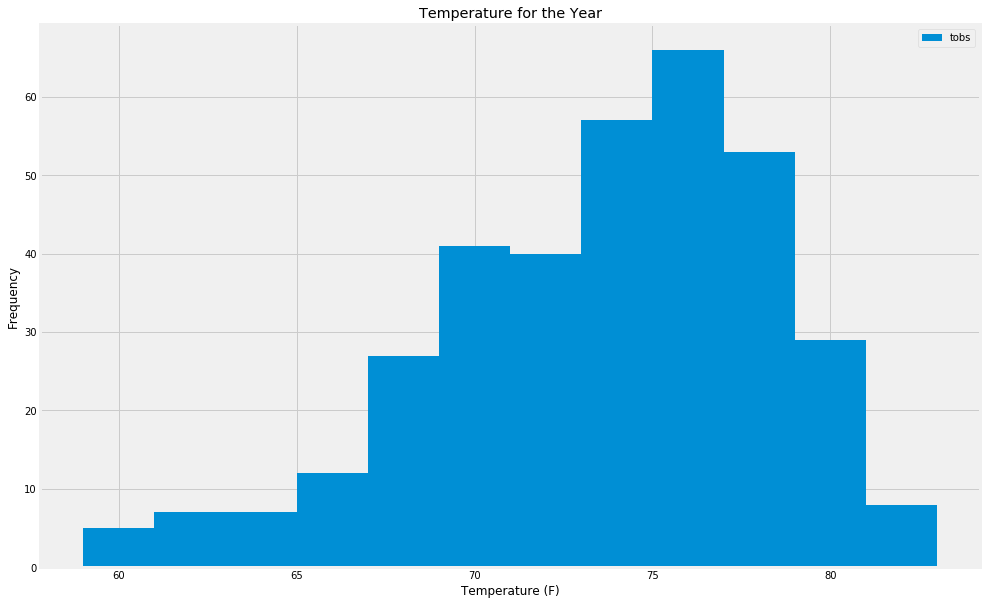

In [50]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_year_q = session.query(Measurement.tobs, Measurement.date).filter(Measurement.station == 'USC00519281').filter(func.date(Measurement.date) >= '2016-08-23').all()
temp_year_p = pd.DataFrame(temp_year_q)
temp_year = temp_year_p.groupby(temp_year_p.date).mean()
temp_year.plot.hist(bins=12, figsize=(15,10))
plt.xlabel('Temperature (F)')
plt.title('Temperature for the Year')


![precipitation](Images/station-histogram.png)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


62.0 68.36585365853658 74.0


<IPython.core.display.Javascript object>


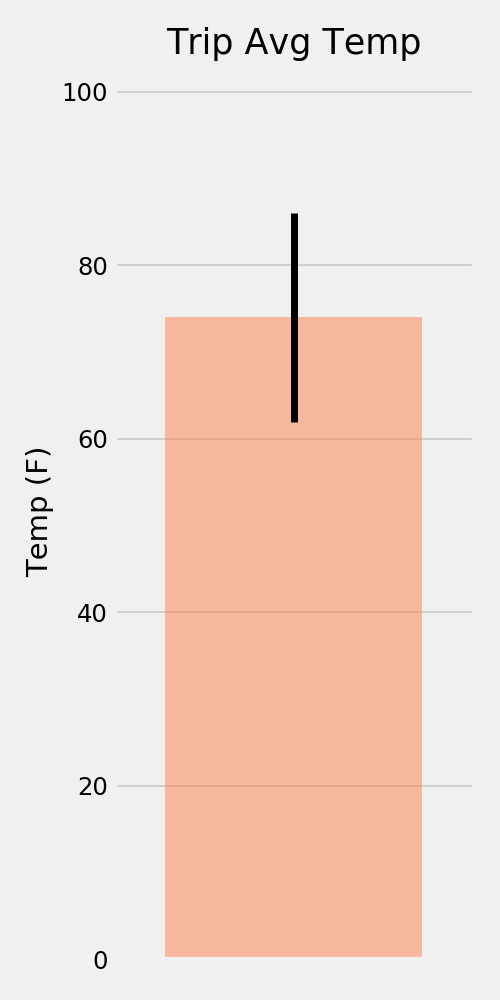

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


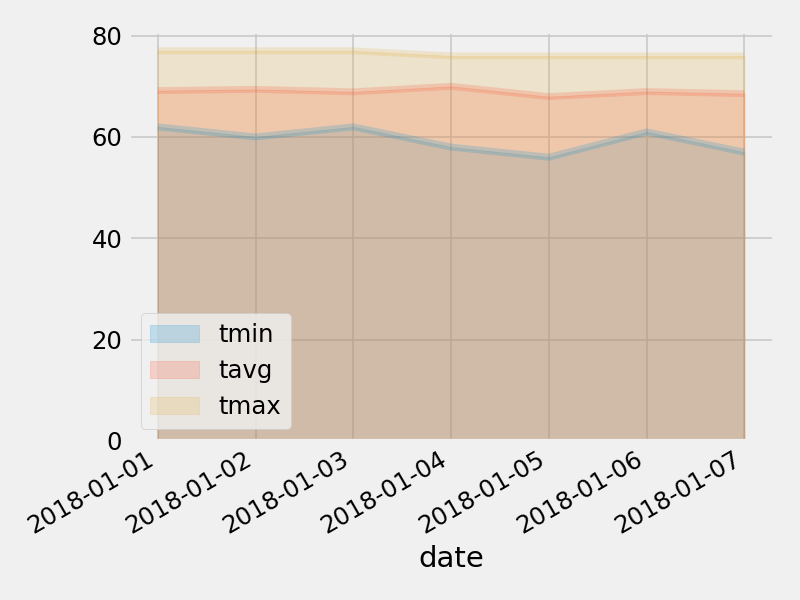

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
